# <span style="color:royalblue"> Rover Project Test Notebook </span><a id='0'></a>

## Brief Information

This mini project represents a rover project of sample searching and returning of NASA. The passing requirement of this project is to map at least ***40%*** of the environment at ***60%*** of fidelity and locate at least ***one*** rock sample in the map.

Belows are python code that tell the robot how to navigate around the environment and search for rock samples but not picking them up. This notebook will only concentrate on how the perception of the robot will implemented in **perception.py** file. **perception.py** will be used in the project to help the robot achieve the passing requirement above. The perception pipeline has following order: 

***Perspective Transfrom*** --> ***Apply Color Thresholding*** --> ***Rover Coordinates Transfrom*** --> ***Apply Image Processing Function***

## <span style="color:black"> Notebook Contents </span>

#### <a href='#1'> 1/ Packages Importation </a>

#### <a href='#2'> 2/ Data Calibration </a>

#### <a href='#3'> 3/ Perspective Transform Function </a>

#### <a href='#4'> 4/ Color Thresholding </a>

#### <a href='#5'> 5/ Coordinate Transformations </a>

#### <a href='#6'> 6/ Read in saved data and ground truth map of the world </a>

#### <a href='#7'> 7/ Image Processing Function </a>

#### <a href='#8'> 8/  Make a video from processed image data </a>

In [2]:
%%HTML
<style> code {background-color : tan !important;} </style>

## <span style="color:black"> 1/ Packages Importation </span><a id='1'></a>

### <a href='#0'><span style="color:royalblue"> Back to content </span></a>

In [6]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
imageio.plugins.ffmpeg.download()

## <span style="color:black"> 2/ Data Calibration</span><a id='2'></a>
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 
### <a href='#0'><span style="color:royalblue"> Back to content </span></a>

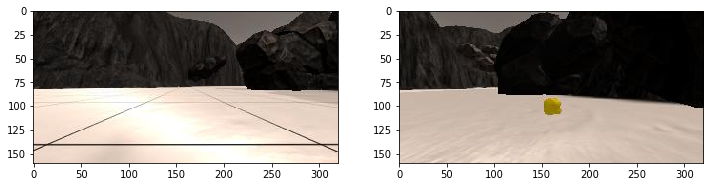

In [7]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/grid_image.jpg'
example_rock = '../calibration_images/rock_image.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## <span style="color:black"> 3/ Perspective Transform </span><a id='3'></a>

Define the perspective transform function from the lesson and test it on an image.
### <a href='#0'><span style="color:royalblue"> Back to content </span></a>

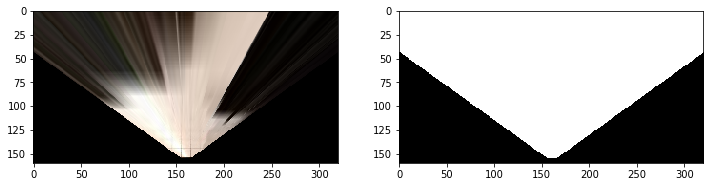

In [8]:
# Randomly select a record image in test_dataset folder
#path = '../test_dataset/IMG/*' # Data folder from Udacity
path = '../record_data/IMG/*'   # Data folder I recorded myself
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])

# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    # Keep same size as input image
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    # Create a mask of a field of view of the robot
    mask = cv2.warpPerspective(np.ones_like(img[:,:,0]), M, (img.shape[1], img.shape[0]))
    return warped, mask

# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 

# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6

# Set a list of coordinate of the square in the source image.
source = np.float32([[14,  140], 
                     [301, 140],
                     [200,  96], 
                     [118,  96]])

# Calculate coordinates of the destination pixel.
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] -              bottom_offset],
                          [image.shape[1]/2 + dst_size, image.shape[0] -              bottom_offset],
                          [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                          [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                          ])

warped, mask = perspect_transform(grid_img, source, destination)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(warped)
plt.subplot(122)
plt.imshow(mask, cmap='gray')
#scipy.misc.imsave('../output/warped_example.jpg', warped)
#imageio.imwrite('../output/warped_example.jpg', warped)
#scipy.misc.imsave('../output/mask_example.jpg', mask)

## <span style="color:black"> 4/ Color Thresholding </span><a id='4'></a>
Define the color thresholding function from the lesson and apply it to the warped image.
### <a href='#0'><span style="color:royalblue"> Back to content </span></a>

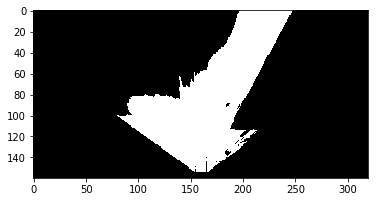

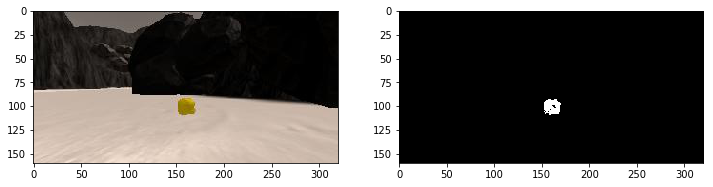

In [12]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    above_thresh =   ((img[:,:,0] > rgb_thresh[0]) \
                    & (img[:,:,1] > rgb_thresh[1]) \
                    & (img[:,:,2] > rgb_thresh[2]))
    
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

def find_rock(img, levels=(110, 110, 50)):
    rock_pix =  ((img[:,:,0] > levels[0]) \
               & (img[:,:,1] > levels[1]) \
               & (img[:,:,2] < levels[2]))
    
    
    color_select = np.zeros_like(img[:,:,0])
    # Index the array of zeros with the boolean array and set to 1
    color_select[rock_pix] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(warped)
rock_map = find_rock(rock_img)

plt.imshow(threshed, cmap='gray')
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(rock_img)
plt.subplot(122)
plt.imshow(rock_map, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

## <span style="color:black"> 5/ Coordinate Transformations </span><a id='5'></a>
Define the functions used to do coordinate transforms and apply them to an image.
### <a href='#0'><span style="color:royalblue"> Back to content </span></a>

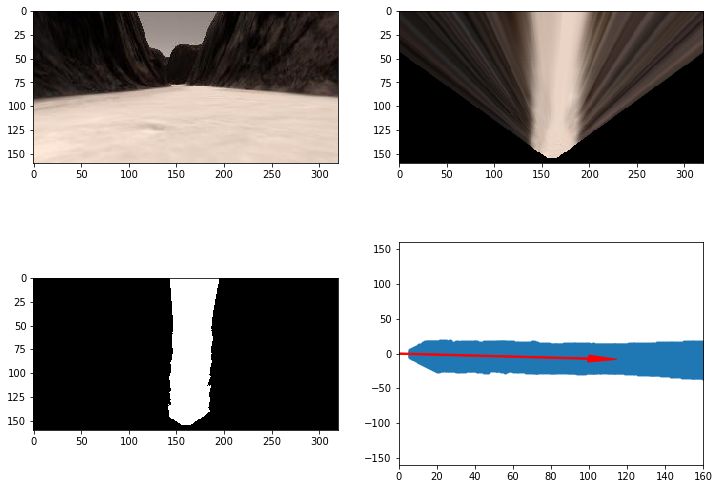

In [25]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped, mask = perspect_transform(image, source, destination)
threshed = color_thresh(warped)
#threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)



## <span style="color:black"> 6/ Read in saved data and ground truth map of the world </span><a id='6'></a>
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.
### <a href='#0'><span style="color:royalblue"> Back to content </span></a>

In [37]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','

#df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
df = pd.read_csv('../record_data/robot_log.csv', delimiter=';', decimal='.')

csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
#red colour = 0, green colour = 1, blue colour = 0
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


## <span style="color:black">7/ Image Processing Function </span><a id='7'></a>

The `process_image()` function contains the perception step processes (functions defined above) to perform image analysis and mapping.

The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the images you saved taking data in the simulator.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  
### <a href='#0'><span style="color:royalblue"> Back to content </span></a>

In [38]:
# Define a function to pass stored images to
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

#------------------------1) Define source and destination points for perspective transform
    dst_size = 5 
    bottom_offset = 6

    source = np.float32([[14,  140], 
                         [301, 140],
                         [200,  96], 
                         [118,  96]])

    destination = np.float32([[img.shape[1]/2 - dst_size, img.shape[0] -              bottom_offset],
                              [img.shape[1]/2 + dst_size, img.shape[0] -              bottom_offset],
                              [img.shape[1]/2 + dst_size, img.shape[0] - 2*dst_size - bottom_offset], 
                              [img.shape[1]/2 - dst_size, img.shape[0] - 2*dst_size - bottom_offset],
                              ])
    
#------------------------2) Perpective transform and mask------------------------
    warped, mask = perspect_transform(img, source, destination)
    
#------------------------3) Apply color threshold to find path and rocks------------------------
    threshed = color_thresh(warped)
    obs_map = np.absolute(np.float32(threshed) - 1) * mask
    xpix, ypix = rover_coords(threshed)
    
#------------------------4) Convert rover-coordinate to world coordinate------------------------
    world_size = data.worldmap.shape[0]
    scale = 2 * dst_size
    xpos = data.xpos[data.count]
    ypos = data.ypos[data.count]
    yaw = data.yaw[data.count]
    x_world, y_world = pix_to_world(xpix, ypix, xpos, ypos, 
                                    yaw, world_size, scale)
    
#------------------------5) Convert obstacle x, y coordinate to the Ground truth map------------------------
    obsxpix, obsypix = rover_coords(obs_map)
    obs_x_world, obs_y_world = pix_to_world(obsxpix, obsypix, xpos, ypos,
                                            yaw, world_size, scale)
    
#------------------------6) Update the world map------------------------
    data.worldmap[y_world, x_world, 2] = 255 # Turn on blue channel
    data.worldmap[obs_y_world, obs_x_world + 2, 0] = 255 # Turn on red channel
    nav_pix = data.worldmap[:,:,2] > 0
    
    data.worldmap[nav_pix, 0] = 0
    
    # Create a rock map
    rock_map = find_rock(warped, levels=(110, 110, 50))
    if rock_map.any():
        rock_x, rock_y = rover_coords(rock_map)
        rock_x_world, rock_y_world = pix_to_world(rock_x, rock_y, xpos, ypos, yaw, world_size, scale)
        data.worldmap[rock_y_world, rock_x_world, :] = 255
        
#------------------------7) Make a mosaic image------------------------
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
        #warped = perspect_transform(img, source, destination)
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Testing Video with the process_image() function.", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

## <span style="color:black">8/ Make a video from processed image data </span><a id='8'></a>
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
### <a href='#0'><span style="color:royalblue"> Back to content </span></a>  

In [39]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../output/test_mapping.mp4
[MoviePy] Writing video ../output/test_mapping.mp4


100%|██████████| 2655/2655 [00:24<00:00, 108.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/test_mapping.mp4 

CPU times: user 23.2 s, sys: 608 ms, total: 23.8 s
Wall time: 24.7 s


## This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

In [41]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Below is an alternative way to create a video in case the above cell did not work.

In [42]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))